# Chapter 3: Classification
This chapter using the MNIST dataset, which consists of 70,000 small images of handwritten digits.

In [1]:
import numpy as np

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
len(mnist['data'])

70000

In [4]:
X, y = mnist['data'], mnist['target']

In [5]:
X.shape

(70000, 784)

In [6]:
y.shape

(70000,)

784 represents 28x28 pixel images. Lets check out a single digit.

In [33]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]

# Reshape from 784 => 28x28
some_digit_image = some_digit.reshape(28,28)

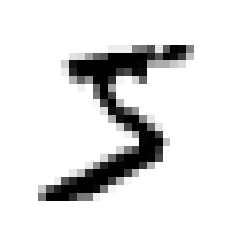

In [34]:
plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [9]:
y[0]

'5'

The labels are currently strings; ML algorithms expect numbers. Let's convert them:

In [10]:
y = y.astype(np.uint8)

In [11]:
type(y[0])

numpy.uint8

Note: `uint8` is an unsigned integer between 0-255. 

## Creating a Test Set
The MNIST dataset comes preshuffled and split into training(0:60000) and test (60000:) sets.

In [12]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a Binary Classifier

In [13]:
y_train_5 = (y_train == 5) # Sets True for all 5s, otherwise False
y_test_5 = (y_test == 5)

 A good starting classifier is SGD (Stochastic Gradient Descent), using Scikit-Learn's `SGDClassifier` class. This classifier is good at handling large datasets efficiently, as it deals with training instances independently and one at a time. This makes it a good candidate for online learning.

In [14]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42) # Add for reproducible results
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

**Issue**
Issue arose regarding the shape of the input. The solution was reshaping the original `some_digit` to 1,-1 (1 x existing). The code below shows the different shapes and conversion.

In [15]:
some_digit.shape

(784,)

In [16]:
some_digit.reshape(1,-1).shape

(1, 784)

In [17]:
some_digit = some_digit.reshape(1,-1)

In [18]:
sgd_clf.predict(some_digit)

array([ True])

## Performance Measures
Evaluating a classifier is even trickier than evaluating a regressor. We'll explore a few different ways to do so.

### Using Cross-Validation

#### Aside: Custom Cross Validation Code
This can be used in place of Scikit-Learn's `cross_val_score()` for more customization.

In [19]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

C:\Users\James\miniconda3\envs\deep-learning\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


0.95035
0.96035
0.9604


#### Using built-in `cross_val_score()`

In [20]:
from sklearn.model_selection import cross_val_score

In [21]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3,
               scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

### "Dumb" Classifier Proves Accuracy isn't Everything

In [22]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [23]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

90% accuracy?! This is because only about 10% of the images are 5's, so 90% are NOT 5's. Since we always guessed that an image would NOT be a 5, we were right 90% of the time.

This shows why accuracy isn't usually the preferred performance measure for classifiers (particularly when working with skewed datasets).

### Confusion Matrix
Using `cross_val_predict()`

In [24]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

### Other Metrics
* **Precision**: Accuracy of the positive predictions. 
    * TP / TP + FP (True Positives / True Positives + False Positives
* **Recall**: Ratio of positive instances correctly detected. 
    * TP / TP + FN (True Positives / True Positives + False Negatives)
    
<img src='Images/confusion-matrix.jpg'>

In [25]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

* Each row represents an *actual* class
* Each column represents a *predicted* class

Above, row 1 considers non-5 images (negative class).
* 53,892 were correctly classified as non-5s (**True Negatives**)
* 687 were wrongly classified as 5s (**False Positives**)

Row 2 considers the images of 5s (positive class)
* 1891 were wrongly classified as 5s (**False Negatives**)
* 3530 were correctly classified as 5s (**True Positives**)

A perfect CLF would have only true positives and true negatives (top-left & bottom-right).

In [62]:
# Mock manipulation showing perfect matrix scores
y_train_perfect_preds = y_train_5
confusion_matrix(y_train_5, y_train_perfect_preds)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

In [27]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) # 3530 / (3530 + 687)

0.8370879772350012

In [63]:
recall_score(y_train_5, y_train_pred) # 3530 / (3530+1891)

0.6511713705958311

Not as good as before.
* When it claims an image represents a 5, it is correct 83.7% of the time (**Precision**).
* It only detects 65.1% of the 5's (**Recall**)

<img src='Images/precision-recall.jpg'>

#### F1 Score - Best of Both Worlds
The F1 score is the harmonic mean of precision and recall, giving more weight to low values.

<img src='Images/f1-score.jpg'>

F1 score favors classifiers that have similar precision and recall. This may or may not be desirable.

**<u>Precision Important</u>:** Classifying safe videos for viewing by children.

**<u>Recall Important</u>:** Detecting shoplifters with 99% recall but only 30% precision. Many false positives, but almost no false negatives (99% of shoplifters caught)

***Precision/Recall trade-off:*** You can't have it both ways; increasing one reduces the other.

#### Decision Threshold
If we raise the *Decision Threshold*, the model is more precise, but recall drops (more false negatives).
If we lower the threshold, the model is less precise, but has greater recall.
<img src='Images/precision-recall-thresholds.jpg'>

*Source: Hands-on Machine Learning - Aurelien Geron*

In [64]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

#### Accessing Scikit-Learn's Decision Threshold Directly
The `decision_function()` method returns a score for a given instance. 

In [65]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [38]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [39]:
threshold = 8000 # Raising the threshold decreases recall
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [66]:
y_scores

array([2164.22030239])

### Compute Precision and Recall for all thresholds
1. Use `cross_val_predict()` function to get scores of all training set instances, using method `decision_function`

In [67]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                            method = 'decision_function')

2. `precision_recall_curve()` computes precision and recall.

In [68]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

3. Use Matplotlib to plot precision and recall as functions of the threshold value

In [73]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.ylim(0,1)
    plt.xlim(-40000,50000)
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(recalls[:-1], 'g-', label='Recall')
    

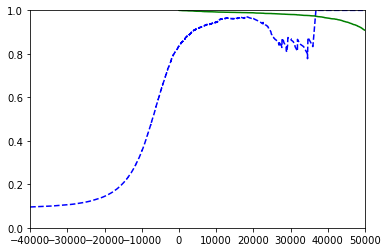

In [74]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

### ROC Curve
**Receiver operating characteristic (ROC)** Curve plots <u>true positive rate</u>(recall) against the <u>false positive rate</u> (ratio of negative instances incorrectly classified as positive).

Equal to 1 - true negative rate (ratio of negative instances correctly classified as negative). TNR also known as specificity.

ROC curve plots <u>sensitivity</u> (recall) vs. <u>1 - specificity</u>.

In [75]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [76]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal
    # Add axis labels and grid
    plot_roc_curve(fpr, tpr)
    plt.show()

#### ROC AUC (area under curve)
A perfect classifier will have  ROC AUC = 1.
A random classifier will have ROC AUC = 0.5.

In [77]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616